Notebook creating features predicting pitch release velocity given discrete features that describe the pitching delivery at key events

Based on Driveline's OpenBiomechanics pitching dataset (credits: https://www.openbiomechanics.org/ )

In [1]:
# import modules
import numpy as np
import pandas as pd


## load data from driveline openbiomechanics dataset poi_metrics.csv on github
url = "https://raw.githubusercontent.com/drivelineresearch/openbiomechanics/main/baseball_pitching/data/poi/poi_metrics.csv"
data = pd.read_csv(url)


Columns with missing values:
lead_hip_transfer_fp_br         8
lead_hip_generation_fp_br       8
lead_hip_absorption_fp_br       8
lead_knee_transfer_fp_br        8
lead_knee_generation_fp_br      8
lead_knee_absorption_fp_br      8
rear_hip_transfer_pkh_fp        8
rear_hip_generation_pkh_fp      8
rear_hip_absorption_pkh_fp      8
rear_knee_transfer_pkh_fp       8
rear_knee_generation_pkh_fp     8
rear_knee_absorption_pkh_fp     8
pelvis_lumbar_transfer_fp_br    8
rear_grf_x_max                  8
rear_grf_y_max                  8
rear_grf_z_max                  8
rear_grf_mag_max                8
rear_grf_angle_at_max           8
lead_grf_x_max                  8
lead_grf_y_max                  8
lead_grf_z_max                  8
lead_grf_mag_max                8
lead_grf_angle_at_max           8
peak_rfd_rear                   8
peak_rfd_lead                   8
dtype: int64

Original shape: (411, 79)
Shape after cleaning: (403, 79)

Selected features (correlation > 0.3):
elbow_tr

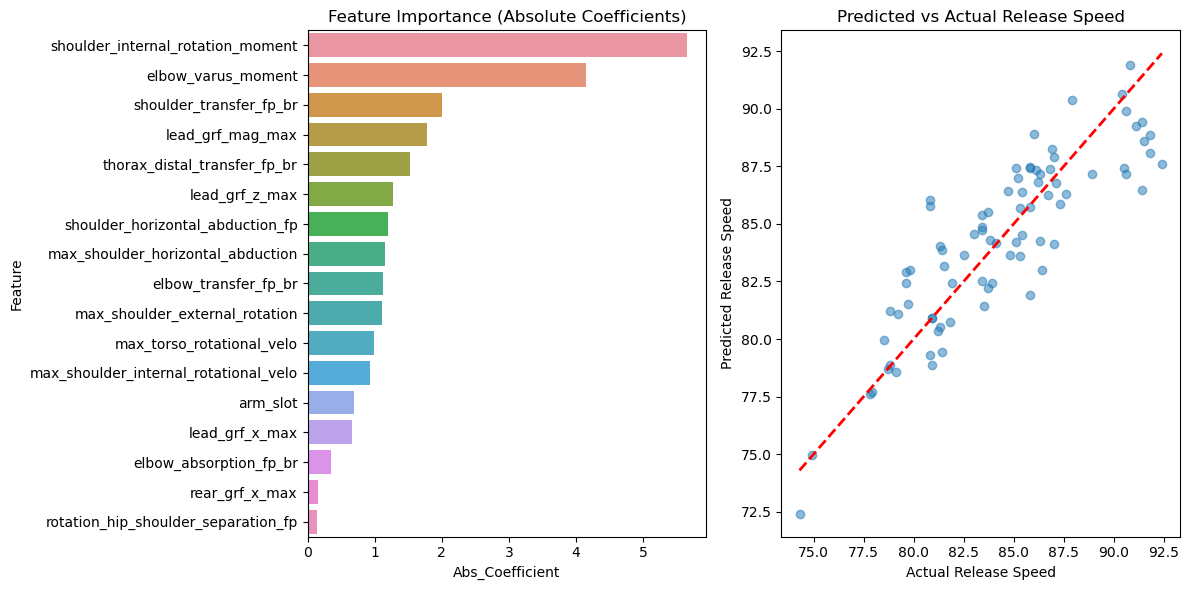

In [6]:
"""
This cell contains functions to clean and analyze pitch data from the driveline openbiomechanics dataset.


"""

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

def clean_pitch_data(df):
    """
    Clean the pitch data by removing infinite values and handling NaN values.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing pitch data
    
    Returns:
    pandas.DataFrame: Cleaned DataFrame
    """
    # Make a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Replace infinite values with NaN
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    
    # Print columns with NaN values and their count
    nan_cols = df_clean.isna().sum()
    print("\nColumns with missing values:")
    print(nan_cols[nan_cols > 0])
    
    # Remove rows with any NaN values
    df_clean = df_clean.dropna()
    
    # Reset index to ensure clean integer index
    df_clean = df_clean.reset_index(drop=True)
    
    print(f"\nOriginal shape: {df.shape}")
    print(f"Shape after cleaning: {df_clean.shape}")
    
    return df_clean

def analyze_pitch_velocity(df, target='pitch_speed_mph', test_size=0.2, correlation_threshold=0.3):
    """
    Perform multiple regression analysis on pitch data to identify factors contributing to release speed.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing pitch data
    target (str): Name of the target variable (default: 'ReleaseSpeed')
    test_size (float): Proportion of data to use for testing (default: 0.2)
    correlation_threshold (float): Minimum correlation coefficient to include variable (default: 0.3)
    
    Returns:
    dict: Dictionary containing regression results and feature importance
    """
    # Clean the data first
    df_clean = clean_pitch_data(df)
    
    # Get correlations and filter features
    correlations = df_clean.corr()[target].sort_values(ascending=False)
    selected_features = correlations[abs(correlations) > correlation_threshold].index.tolist()
    selected_features.remove(target)
    
    print(f"\nSelected features (correlation > {correlation_threshold}):")
    for feat in selected_features:
        print(f"{feat}: {correlations[feat]:.3f}")
    
    # Prepare features and target
    X = df_clean[selected_features].copy()  # Make explicit copies
    y = df_clean[target].copy()
    
    # Ensure indices match
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    
    # Reset indices after split to ensure alignment
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Fit OLS regression for detailed statistics
    X_train_sm = sm.add_constant(X_train)
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    
    # Fit sklearn model for predictions
    model_sk = LinearRegression()
    model_sk.fit(X_train, y_train)
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': model_sk.coef_,
        'Abs_Coefficient': abs(model_sk.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Calculate predictions and R-squared
    y_pred = model_sk.predict(X_test)
    r2_score = model_sk.score(X_test, y_test)
    
    # Create visualizations
    plt.figure(figsize=(12, 6))
    
    # Feature importance plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Importance (Absolute Coefficients)')
    
    # Predicted vs Actual plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Release Speed')
    plt.ylabel('Predicted Release Speed')
    plt.title('Predicted vs Actual Release Speed')
    
    plt.tight_layout()
    
    return {
        'model_summary': model_sm.summary(),
        'feature_importance': feature_importance,
        'r2_score': r2_score,
        'model': model_sk,
        'selected_features': selected_features,
        'clean_data': df_clean
    }
# Run the analysis on the fastball data

fastball = data[data['pitch_type'] == 'FF']

# remove unnecessary columns
fastball_data = fastball.drop(columns=['p_throws', 'pitch_type'])




# # Only event based metrics
# event_data = fastball_data.drop(columns=['max_shoulder_internal_rotational_velo', 'max_elbow_extension_velo', 'max_torso_rotational_velo',
#                                          'max_rotation_hip_shoulder_separation','max_elbow_flexion','max_shoulder_external_rotation','lead_knee_extension_angular_velo_max',
#                                          'max_cog_velo_x','torso_rotation_min','max_pelvis_rotational_velo','elbow_varus_moment','shoulder_internal_rotation_moment',
#                                          'timing_peak_torso_to_peak_pelvis_rot_velo','max_shoulder_horizontal_abduction','rear_grf_x_max','rear_grf_y_max','rear_grf_z_max',
#                                          'rear_grf_mag_max','rear_grf_angle_at_max','lead_grf_x_max','lead_grf_y_max','lead_grf_z_max','lead_grf_mag_max', 'lead_grf_angle_at_max',
#                                           'shoulder_transfer_fp_br','shoulder_generation_fp_br','shoulder_absorption_fp_br' , 'elbow_transfer_fp_br', 'elbow_generation_fp_br','elbow_absorption_fp_br',
#                                           'lead_hip_transfer_fp_br','lead_hip_generation_fp_br','lead_hip_absorption_fp_br','rear_hip_transfer_pkh_fp','rear_hip_generation_pkh_fp','rear_hip_absorption_pkh_fp',
#                                           'rear_knee_transfer_pkh_fp','rear_knee_generation_pkh_fp','rear_knee_absorption_pkh_fp','lead_knee_transfer_fp_br','lead_knee_generation_fp_br','lead_knee_absorption_fp_br',
#                                           'pelvis_lumbar_transfer_fp_br', 'thorax_distal_transfer_fp_br'])
event_data = fastball_data

event_results = analyze_pitch_velocity(event_data)
print("\nModel R-squared:", event_results['r2_score'])
print("\nTop 5 Most Important Features:")
print(event_results['feature_importance'].head())
print("\nDetailed Statistics:")
print(event_results['model_summary']) 

In [7]:
# # Run a standard correlation on the event data and pitch_speed_mph
# correlation = event_data.corr()['pitch_speed_mph'].sort_values(ascending=False)
# print(correlation)

# Run a standard correlation on fastball data and pitch_speed_mph
correlation = fastball_data.corr()['pitch_speed_mph'].sort_values(ascending=False)
print(correlation)

pitch_speed_mph                        1.000000
elbow_transfer_fp_br                   0.690945
shoulder_transfer_fp_br                0.651221
thorax_distal_transfer_fp_br           0.644966
shoulder_internal_rotation_moment      0.524939
                                         ...   
elbow_flexion_fp                      -0.146274
glove_shoulder_external_rotation_fp   -0.201238
stride_angle                          -0.209956
torso_lateral_tilt_br                 -0.216369
arm_slot                              -0.300774
Name: pitch_speed_mph, Length: 79, dtype: float64


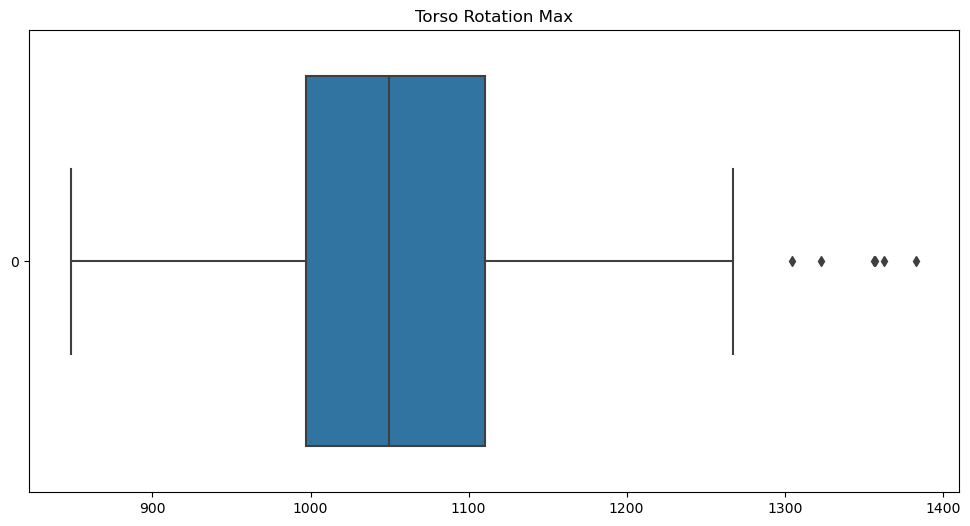

c:\Users\jaspe\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


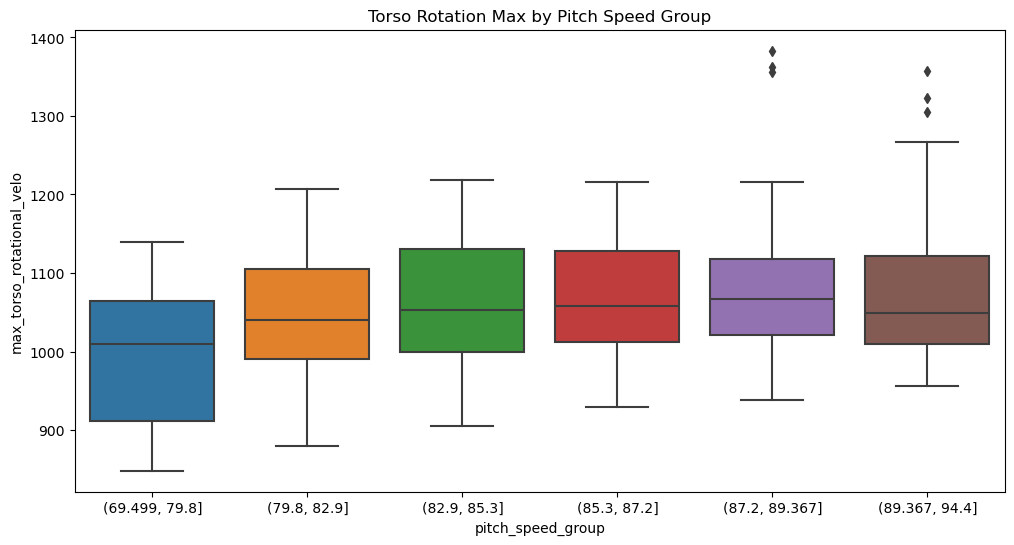

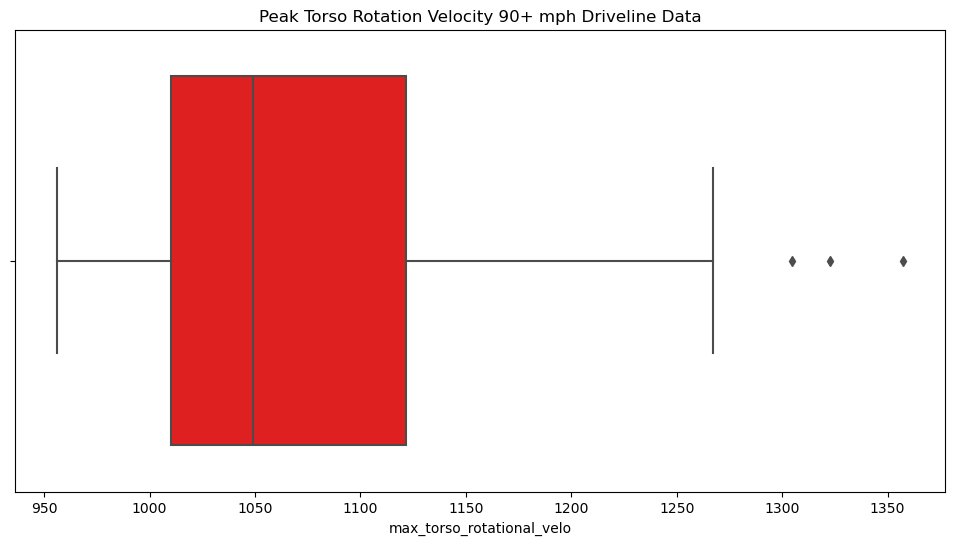

In [8]:
# Horizontal boxplot of torso_rotation_max
plt.figure(figsize=(12, 6))
sns.boxplot(data['max_torso_rotational_velo'], orient = 'h')
plt.title('Torso Rotation Max')
plt.show()

# Split data into 5 groups based on pitch velocity (pitch_speed_mph) and plot torso_rotation_max
data['pitch_speed_group'] = pd.qcut(data['pitch_speed_mph'], q=6)
plt.figure(figsize=(12, 6))
sns.boxplot(x='pitch_speed_group', y='max_torso_rotational_velo', data=data, orient='v')
plt.title('Torso Rotation Max by Pitch Speed Group')
plt.show()

# Rename the pitch group witht the highest velocity to 'Fastest' and plot just that one
data['pitch_speed_group'] = data['pitch_speed_group'].cat.rename_categories(['Slowest', '2', '3', '4', '5', 'Fastest'])
fastest_group = data[data['pitch_speed_group'] == 'Fastest']
plt.figure(figsize=(12, 6))
sns.boxplot(x='max_torso_rotational_velo', data=fastest_group, orient='h', color='red')
plt.title('Peak Torso Rotation Velocity 90+ mph Driveline Data')
plt.show()